In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns


✅ Data successfully loaded: /home/awail/PycharmProjects/kaggle/RoadAccident/train.csv
🔠 Encoded DataFrame shape: (517754, 25)
   num_lanes  curvature  speed_limit  num_reported_accidents  accident_risk  \
0          2       0.06           35                       1           0.13   
1          4       0.99           35                       0           0.35   
2          4       0.63           70                       2           0.30   
3          4       0.07           35                       1           0.21   
4          1       0.58           60                       1           0.56   

   road_type_highway  road_type_rural  road_type_urban  lighting_daylight  \
0              False            False             True               True   
1              False            False             True               True   
2              False             True            False              False   
3               True            False            False              False   
4             

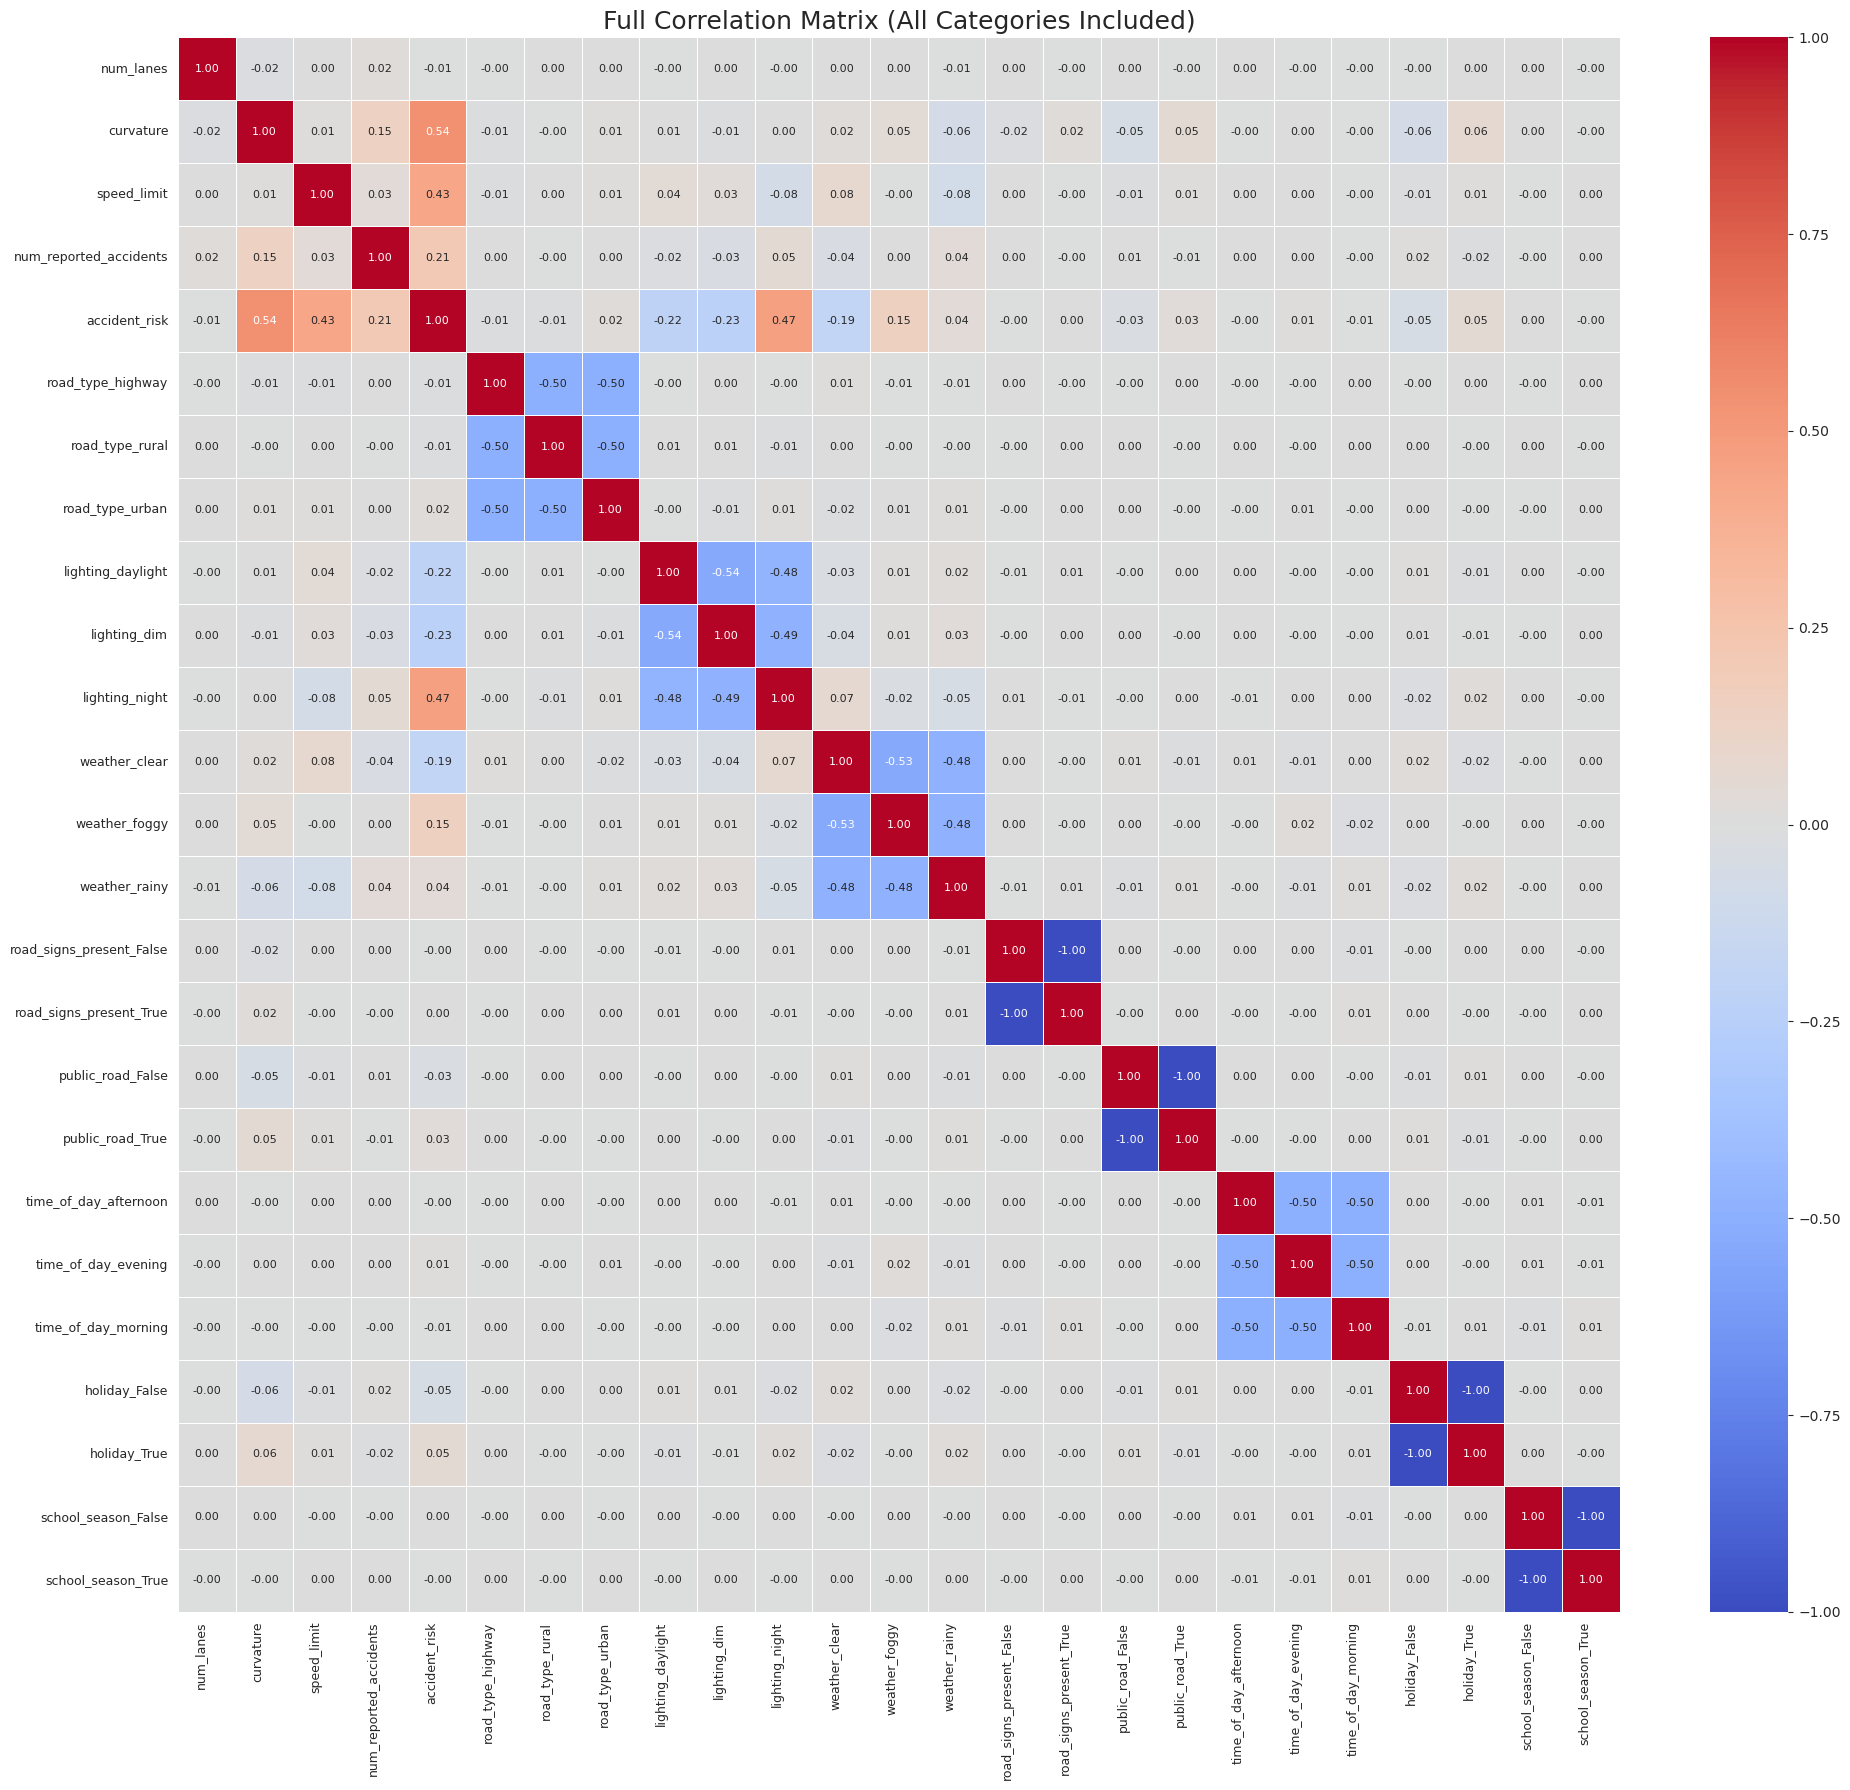

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_road_accident_correlation():
    """
    Loads 'train.csv', one-hot encodes all categorical features (keeping all categories),
    computes correlation matrix, prints top correlated features with 'accident_risk',
    and displays a labeled heatmap.
    """

    # --- 1. Load Data ---
    path = "/home/awail/PycharmProjects/kaggle/RoadAccident/train.csv"
    train_df = pd.read_csv(path)
    print(f"✅ Data successfully loaded: {path}")

    # Drop 'id' if it exists
    if 'id' in train_df.columns:
        train_df = train_df.drop('id', axis=1)

    # --- 2. One-Hot Encode ALL categorical columns ---
    categorical_cols = [
        'road_type', 'lighting', 'weather', 'road_signs_present',
        'public_road', 'time_of_day', 'holiday', 'school_season'
    ]

    cols_to_encode = [col for col in categorical_cols if col in train_df.columns]
    df_encoded = pd.get_dummies(train_df, columns=cols_to_encode, drop_first=False)

    print(f"🔠 Encoded DataFrame shape: {df_encoded.shape}")
    print(df_encoded.head(), "\n")

    # --- 3. Compute correlation matrix ---
    correlation_matrix = df_encoded.corr(numeric_only=True)

    # --- 4. Display top correlations with 'accident_risk' ---
    if 'accident_risk' in correlation_matrix.columns:
        target_corr = correlation_matrix['accident_risk'].sort_values(ascending=False)
        print("📊 Top 15 features correlated with 'accident_risk':")
        print(target_corr[1:16].to_string(), "\n")
    else:
        print("⚠️ Warning: 'accident_risk' not found in dataset columns!")

    # --- 5. Visualize correlation matrix ---
    plt.figure(figsize=(20, 18))
    sns.heatmap(
        correlation_matrix,
        annot=True,
        fmt=".2f",
        cmap='coolwarm',
        linewidths=0.5,
        cbar=True,
        annot_kws={"size": 8}
    )
    plt.title("Full Correlation Matrix (All Categories Included)", fontsize=18)
    plt.xticks(rotation=90, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()

    # Save heatmap to file
    plt.savefig("correlation_heatmap_full.png", dpi=300)
    print("💾 Heatmap saved as correlation_heatmap_full.png")

    # Uncomment below to view the heatmap interactively
    # plt.show()


if __name__ == "__main__":
    analyze_road_accident_correlation()


✅ Data successfully loaded: /home/awail/PycharmProjects/kaggle/RoadAccident/train.csv
📊 Showing features with |correlation| ≥ 0.04
accident_risk             1.000000
curvature                 0.543946
lighting_night            0.465798
speed_limit               0.430898
num_reported_accidents    0.213891
weather_foggy             0.149758
holiday_True              0.051129
holiday_False            -0.051129
weather_clear            -0.185085
lighting_daylight        -0.215109
lighting_dim             -0.233032
Name: accident_risk, dtype: float64 

💾 Filtered heatmap saved as filtered_correlation_heatmap_r0.04.png


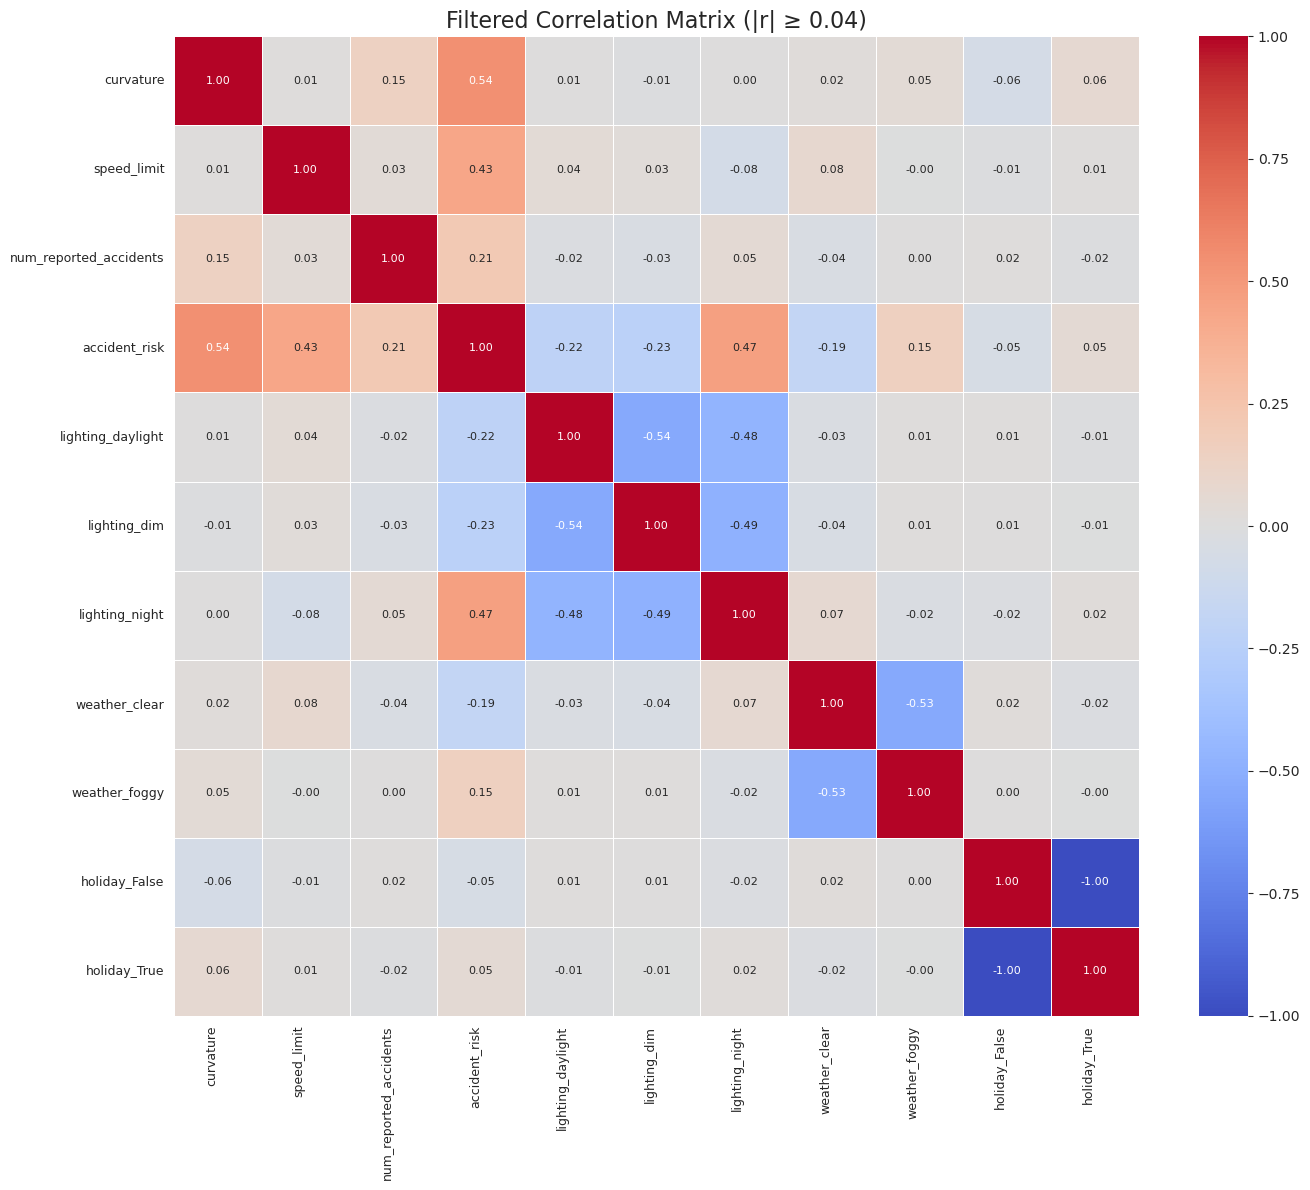

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_road_accident_correlation(corr_threshold=0.05):
    """
    Loads 'train.csv', one-hot encodes categorical variables,
    filters out features with low correlation to 'accident_risk',
    and plots a focused correlation heatmap.
    """

    # --- 1. Load Data ---
    path = "/home/awail/PycharmProjects/kaggle/RoadAccident/train.csv"
    train_df = pd.read_csv(path)
    print(f"✅ Data successfully loaded: {path}")

    # Drop 'id' if it exists
    if 'id' in train_df.columns:
        train_df = train_df.drop('id', axis=1)

    # --- 2. One-Hot Encode Categorical Columns ---
    categorical_cols = [
        'road_type', 'lighting', 'weather', 'road_signs_present',
        'public_road', 'time_of_day', 'holiday', 'school_season'
    ]

    cols_to_encode = [col for col in categorical_cols if col in train_df.columns]
    df_encoded = pd.get_dummies(train_df, columns=cols_to_encode, drop_first=False)

    # --- 3. Compute Correlation Matrix ---
    correlation_matrix = df_encoded.corr(numeric_only=True)

    # --- 4. Focus on correlation with 'accident_risk' ---
    if 'accident_risk' not in correlation_matrix.columns:
        raise ValueError("❌ 'accident_risk' not found in dataset!")

    target_corr = correlation_matrix['accident_risk']

    # --- 5. Filter features by absolute correlation threshold ---
    selected_features = target_corr[abs(target_corr) >= corr_threshold].index
    filtered_corr = correlation_matrix.loc[selected_features, selected_features]

    print(f"📊 Showing features with |correlation| ≥ {corr_threshold}")
    print(target_corr[abs(target_corr) >= corr_threshold].sort_values(ascending=False), "\n")

    # --- 6. Visualize filtered correlation matrix ---
    plt.figure(figsize=(14, 12))
    sns.heatmap(
        filtered_corr,
        annot=True,
        fmt=".2f",
        cmap='coolwarm',
        linewidths=0.5,
        annot_kws={"size": 8}
    )
    plt.title(f"Filtered Correlation Matrix (|r| ≥ {corr_threshold})", fontsize=16)
    plt.xticks(rotation=90, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()

    # Save filtered heatmap
    plt.savefig(f"filtered_correlation_heatmap_r{corr_threshold}.png", dpi=300)
    print(f"💾 Filtered heatmap saved as filtered_correlation_heatmap_r{corr_threshold}.png")

    # Uncomment if you want to view interactively
    # plt.show()


if __name__ == "__main__":
    # You can adjust threshold as needed
    analyze_road_accident_correlation(corr_threshold=0.04)


--- Data loaded successfully ---

--- Top 20 Correlations with 'accident_risk' ---
speed_limit_curvature           0.675621
lighting_curvature              0.594415
curvature                       0.543946
lighting_night                  0.465798
speed_limit                     0.430898
curvature_num_lanes             0.397810
lighting_numeric                0.393860
weather_curvature               0.372260
lighting_weather_night_foggy    0.325450
speedlimit_weather              0.271329
speed_limit_num_lanes           0.248164
lighting_weather_night_rainy    0.235994
num_reported_accidents          0.213891
lighting_weather_night_clear    0.158532
weather_foggy                   0.149758
weather_numeric                 0.130064
holiday_True                    0.051129
weather_rainy                   0.036137
public_road_True                0.031032
road_type_urban                 0.021463


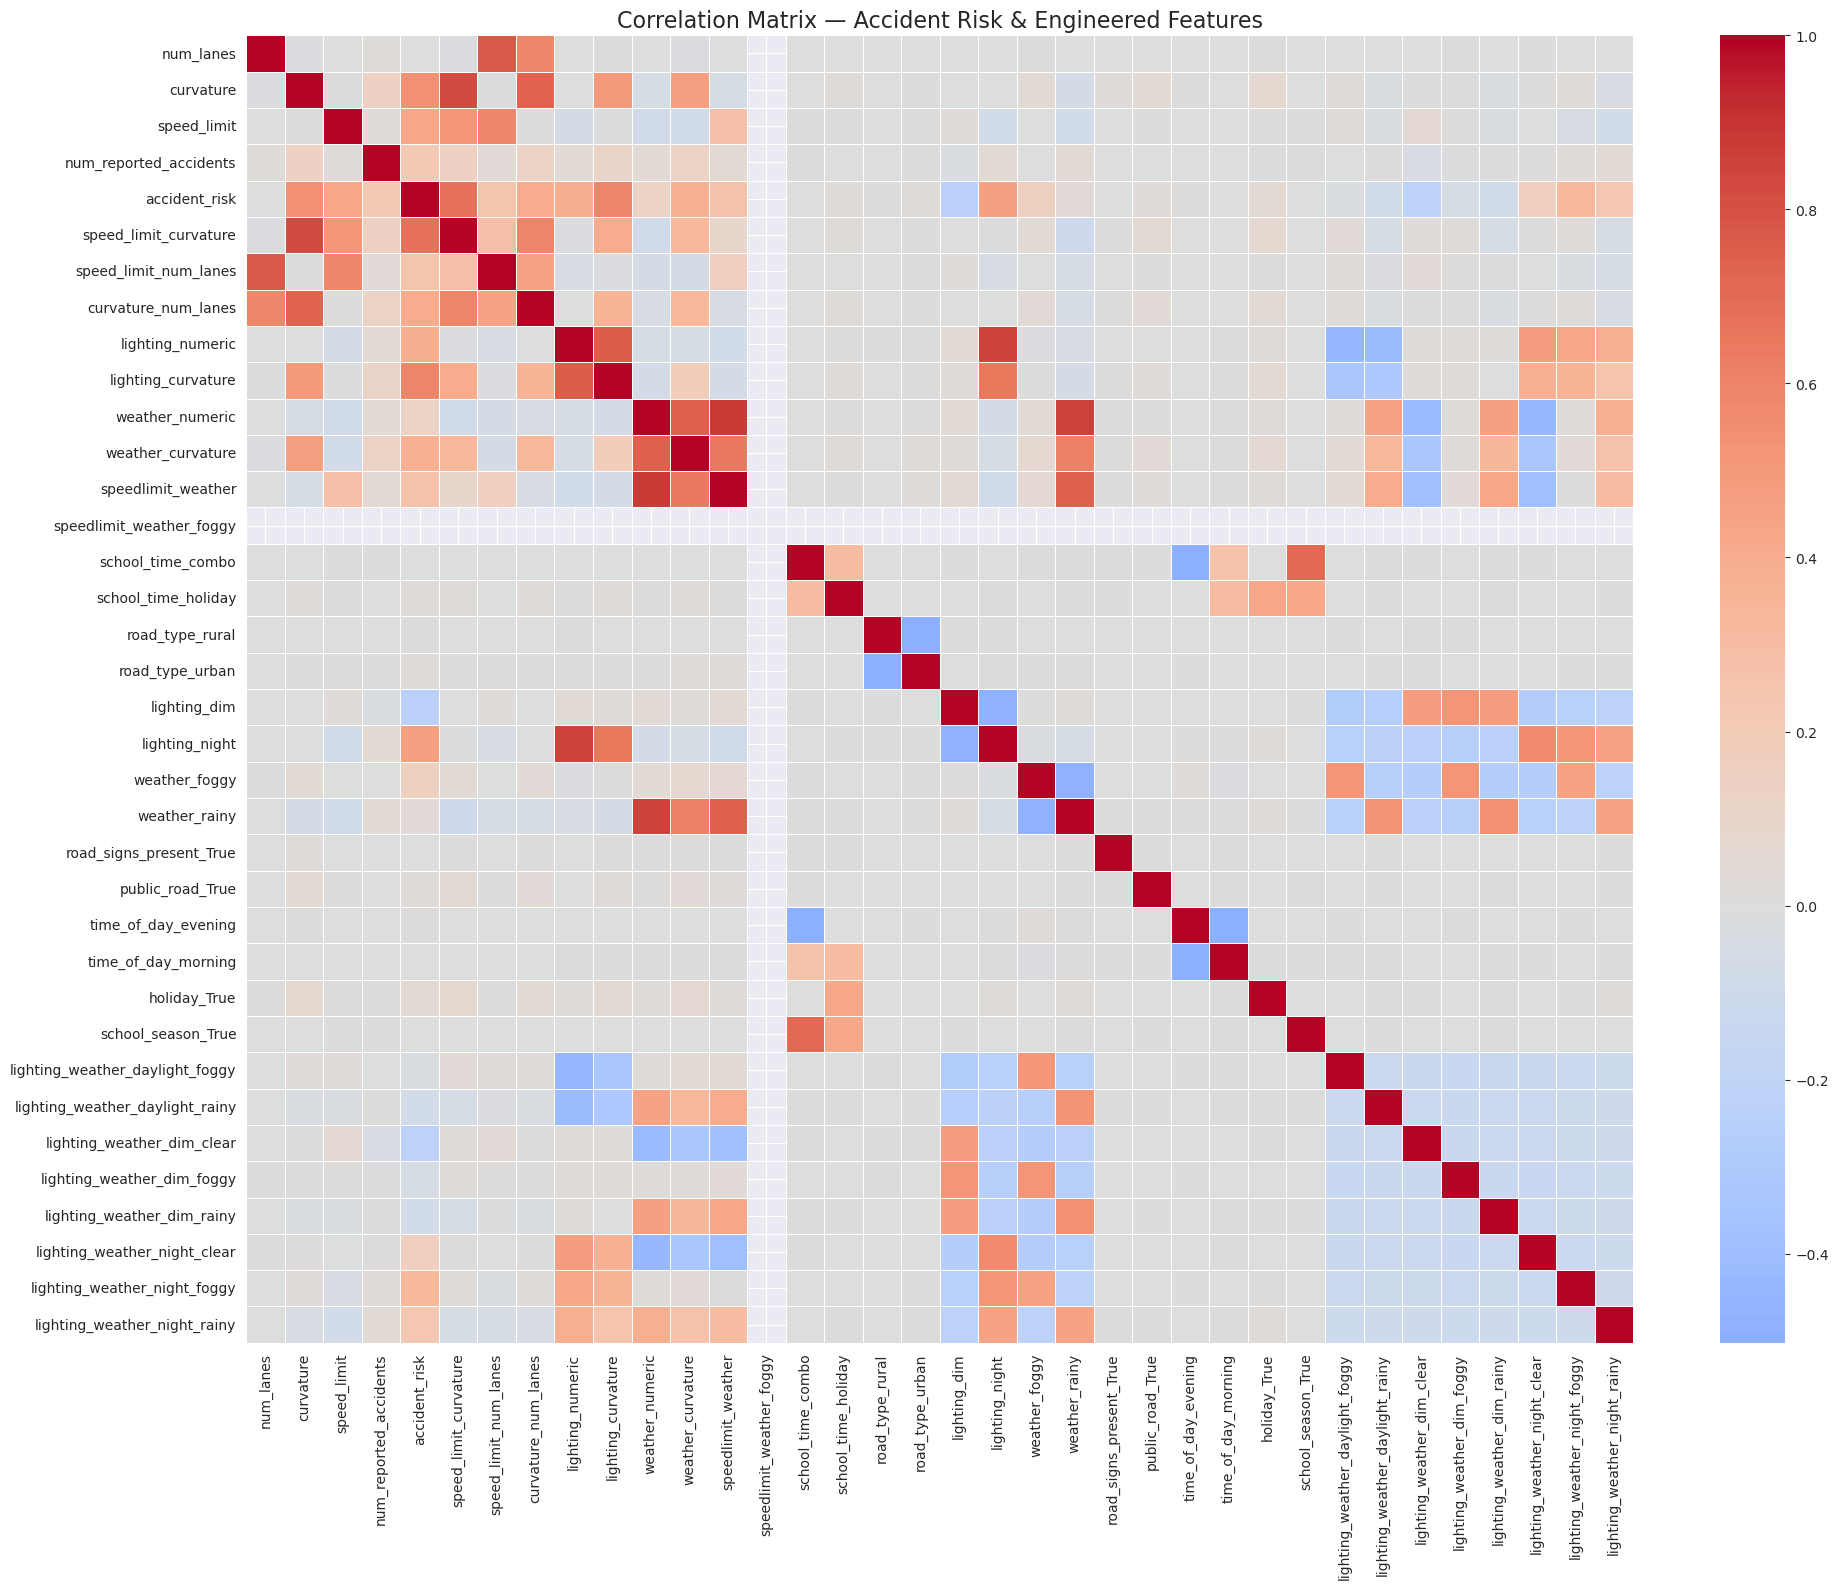


✅ Correlation matrix heatmap generated.


In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_accident_risk_correlations():
    # ======================
    # 1️⃣ LOAD DATA
    # ======================
    df = pd.read_csv("/home/awail/PycharmProjects/kaggle/RoadAccident/train.csv")
    print("--- Data loaded successfully ---")

    if 'id' in df.columns:
        df = df.drop('id', axis=1)

    # ======================
    # 2️⃣ FEATURE ENGINEERING
    # ======================
    df["speed_limit_curvature"] = df["speed_limit"] * df["curvature"]
    df["speed_limit_num_lanes"] = df["speed_limit"] * df["num_lanes"]
    df["curvature_num_lanes"] = df["curvature"] * df["num_lanes"]

    df["lighting_weather"] = df["lighting"].astype(str) + "_" + df["weather"].astype(str)
    df["lighting_numeric"] = df["lighting"].astype("category").cat.codes
    df["lighting_curvature"] = df["lighting_numeric"] * df["curvature"]

    df["weather_numeric"] = df["weather"].astype("category").cat.codes
    df["weather_curvature"] = df["weather_numeric"] * df["curvature"]
    df["speedlimit_weather"] = df["speed_limit"] * df["weather_numeric"]
    df["speedlimit_weather_foggy"] = np.where(df["weather"] == "Foggy", df["speed_limit"], 0)

    df["school_time_combo"] = np.where(
        (df["school_season"] == True) &
        (df["time_of_day"].isin(["morning", "afternoon"])),
        1, 0
    )

    df["school_time_holiday"] = (
        df["school_season"].astype(int)
        * df["holiday"].astype(int)
        * df["time_of_day"].astype("category").cat.codes
    )

    # ======================
    # 3️⃣ ENCODE CATEGORICAL FEATURES
    # ======================
    categorical_cols = [
        'road_type', 'lighting', 'weather', 'road_signs_present',
        'public_road', 'time_of_day', 'holiday', 'school_season', 'lighting_weather'
    ]

    df = pd.get_dummies(df, columns=[c for c in categorical_cols if c in df.columns], drop_first=True)

    # ======================
    # 4️⃣ CORRELATION MATRIX
    # ======================
    corr = df.corr()

    if 'accident_risk' in corr.columns:
        target_corr = corr['accident_risk'].sort_values(ascending=False)
        print("\n--- Top 20 Correlations with 'accident_risk' ---")
        print(target_corr[1:21].to_string())
    else:
        print("⚠️ 'accident_risk' not found in dataset columns.")
        return

    # ======================
    # 5️⃣ VISUALIZE CORRELATION HEATMAP
    # ======================
    plt.figure(figsize=(20, 16))
    sns.heatmap(
        corr,
        cmap='coolwarm',
        center=0,
        annot=False,
        linewidths=0.5,
        cbar=True
    )
    plt.title("Correlation Matrix — Accident Risk & Engineered Features", fontsize=16)
    plt.tight_layout()
    plt.show()

    print("\n✅ Correlation matrix heatmap generated.")

if __name__ == "__main__":
    analyze_accident_risk_correlations()
